
# NLP From Scratch: Classifying Names with a Character-Level RNN
**Author**: [Sean Robertson](https://github.com/spro)

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This tutorial, along with two other
Natural Language Processing (NLP) "from scratch" tutorials
:doc:`/intermediate/char_rnn_generation_tutorial` and
:doc:`/intermediate/seq2seq_translation_tutorial`, show how to
preprocess data to model NLP. In particular these tutorials do not
use many of the convenience functions of `torchtext`, so you can see how
preprocessing to model NLP works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```
## Recommended Preparation

Before starting this tutorial it is recommended that you have installed PyTorch,
and have a basic understanding of Python programming language and Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
   and learn the basics of Tensors
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

<div class="alert alert-info"><h4>Note</h4><p>Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.</p></div>

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기

**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)
  **번역**: [황성수](https://github.com/adonisues), [김제필](https://github.com/garlicvread)


단어를 분류하기 위해 기초적인 문자-단위 RNN을 구축하고 학습할 예정입니다.
이 튜토리얼에서는(이후 2개 튜토리얼과 함께) NLP 모델링을 위해 `torchtext` 의
수많은 편리한 기능을 사용하지 않고도 어떻게 데이터를 전처리하는지 "기초부터(from scratch)"
보여주므로 NLP 모델링을 위한 데이터 전처리가 저수준에서 어떻게 진행되는지 알 수 있습니다.
문자-단위 RNN은 단어를 문자의 연속으로 읽어 들여서 각 단계의 예측과
"은닉 상태(Hidden State)"를 출력하고, 다음 단계에 이전 단계의 은닉 상태를 전달합니다.
단어가 속한 클래스로 출력되도록 최종 예측으로 선택합니다.

구체적으로, 18개 언어로 된 수천 개의 성(姓)을 훈련시키고,
철자에 따라 이름이 어떤 언어인지 예측합니다:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**추천 자료:**

Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다:

-  https://pytorch.org/ 설치 안내
-  :doc:`/beginner/deep_learning_60min_blitz` PyTorch 시작하기
-  :doc:`/beginner/pytorch_with_examples` 넓고 깊은 통찰을 위한 자료
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료

RNN과 그 작동 방식을 아는 것 또한 유용합니다:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   실생활 예제를 보여 줍니다.
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   LSTM에 관한 것이지만 RNN에 관해서도 유익합니다.

## 데이터 준비

<div class="alert alert-info"><h4>Note</h4><p>[여기](https://download.pytorch.org/tutorial/data.zip)_ 에서 데이터를 다운로드 받고
   현재 디렉토리에 압축을 푸십시오.</p></div>

``data/names`` 디렉토리에는 ``[Language].txt`` 라는 18 개의 텍스트 파일이 있습니다.
각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어 있습니다.
(그러나, 유니코드에서 ASCII로 변환해야 함).

각 언어 별로 이름 목록 사전 ``{language: [names ...]}`` 을 만듭니다.
일반 변수 "category" 와 "line" (우리의 경우 언어와 이름)은 이후의 확장성을 위해 사용됩니다.

<div class="alert alert-info"><h4>Note</h4><p>역자 주: "line" 에 입력을 "category"에 클래스를 적용하여 다른 문제에도 활용할 수 있습니다.
   여기서는 "line"에 이름(ex. Robert)을 입력으로, "category"에 클래스(ex. english)로 사용합니다.</p></div>


In [9]:
import os, zipfile
from pathlib import Path

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall()

In [10]:
%matplotlib inline

from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt']
Slusarski


In [12]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




이제 각 ``category`` (언어)를 ``line`` (이름)에 매핑하는 사전인
``category_lines`` 를 만들었습니다. 나중에 참조할 수 있도록
``all_categories`` (언어 목록)와 ``n_categories`` 도 추적합니다.




In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




### 이름을 Tensor로 변경

이제 모든 이름을 체계화했으므로, 이를 활용하기 위해 Tensor로
변환해야 합니다.

하나의 문자를 표현하기 위해 크기가 ``<1 x n_letters>`` 인
"One-Hot 벡터"를 사용합니다. One-Hot 벡터는 현재 문자의
주소에는 1이, 그 외 나머지 주소에는 0이 채워진 벡터입니다.
예시 ``"b" = <0 1 0 0 0 ...>`` .

단어를 만들기 위해 One-Hot 벡터들을 2차원 행렬
``<line_length x 1 x n_letters>`` 에 결합시킵니다.

위에서 보이는 추가적인 1차원은 PyTorch에서 모든 것이 배치(batch)에 있다고 가정하기
때문에 발생합니다. 여기서는 배치 크기 1을 사용하고 있습니다.




In [18]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# Finde letter index from all_letters, e.g., "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.




## 네트워크 생성

Autograd 전에, Torch에서 RNN(recurrent neural network) 생성은
여러 시간 단계 걸쳐서 계층의 매개변수를 복제하는 작업을 포함합니다.
계층은 은닉 상태와 변화도(Gradient)를 가지며, 이제 이것들은 그래프 자체에서
완전히 처리됩니다. 이는 feed-forward 계층과
같은 매우 "순수한" 방법으로 RNN을 구현할 수 있음을 의미합니다.

이 RNN 모듈은
입력 및 은닉 상태로 작동하는 2개의 선형 계층이며,
출력 다음에 ``LogSoftmax`` 계층이 있습니다.

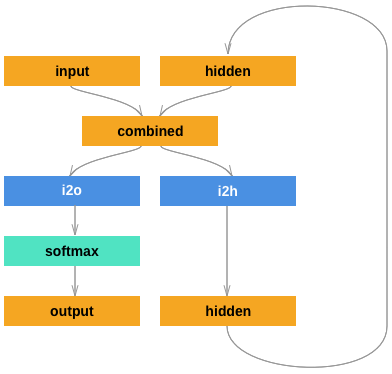




In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과
이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다.
출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를
돌려받습니다.




In [22]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




효율성을 위해서 매 단계마다 새로운 Tensor를 만들고 싶지 않기 때문에
``letterToTensor`` 대신 ``lineToTensor`` 를 잘라서 사용할
것입니다. 이것은 Tensor의 사전 연산(pre-computing) 배치에 의해
더욱 최적화될 수 있습니다.




In [25]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
# print(next_hidden)

tensor([[-2.8884, -2.9092, -2.8593, -2.9263, -2.8240, -2.8297, -2.9267, -2.7961,
         -2.9801, -2.8887, -2.9401, -2.9154, -2.9170, -2.8141, -2.9181, -2.8549,
         -2.9522, -2.9089]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




보시다시피 출력은 ``<1 x n_categories>`` Tensor이고, 모든 항목은
해당 카테고리의 우도(likelihood)입니다(더 높은 것이 더 확률 높음).




## Training
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




## 학습
학습 준비
----------------------

학습에 들어가기 전, 몇몇 도움 되는 함수를 만들어야 합니다.
첫째는 우리가 알아낸 각 카테고리의 우도인 네트워크 출력을 해석하는 함수입니다.
가장 큰 값의 주소를 알기 위해서 ``Tensor.topk`` 를 사용할 수 있습니다.

역자 주: 네트워크 출력(각 카테고리의 우도)으로
가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호를 반환




In [26]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 7)


We will also want a quick way to get a training example (a name and its
language):




학습 예시(하나의 이름과 그 언어)를 얻는 빠른 방법도 필요합니다.:




In [32]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Mogilnichenko
category = French / line = Tremble
category = German / line = Wolf
category = Czech / line = Kofel
category = Japanese / line = Tsukamoto
category = Greek / line = Vourlis
category = English / line = Berry
category = English / line = Ridgwell
category = Irish / line = Cathain
category = Scottish / line = Ramsay


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




### 네트워크 학습

이제 이 네트워크를 학습하는 데 필요한 예시(학습 데이터)를 보여주고 추정합니다.
만일 틀렸다면 알려 줍니다.

RNN의 마지막 계층이 ``nn.LogSoftmax`` 이므로 손실 함수로
``nn.NLLLoss`` 가 적합합니다.




In [33]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




각 학습 루프는 다음과 같습니다:

-  입력과 목표 Tensor 생성
-  0 로 초기화 된 은닉 상태 생성
-  각 문자 읽기

-  다음 문자를 위한 은닉 상태 유지

-  목표와 최종 출력 비교
-  역전파
-  출력과 손실 반환




In [35]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = - learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




이제 예시 데이터를 사용하여 실행해야 합니다. ``train`` 함수가 출력과 손실을
반환하기 때문에 추측을 화면에 출력하고 도식화를 위한 손실을 추적할 수
있습니다. 1000개의 예시 데이터가 있기 때문에 ``print_every`` 예제만
출력하고, 손실의 평균을 얻습니다.




In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else  '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.7850 Lam / Arabic ✗ (Chinese)
10000 10% (0m 9s) 2.1409 Allcott / English ✓
15000 15% (0m 13s) 0.1027 Sasaki / Japanese ✓
20000 20% (0m 17s) 2.7883 Mathieu / Vietnamese ✗ (French)
25000 25% (0m 22s) 0.8644 Hong / Korean ✓
30000 30% (0m 27s) 0.9818 Ha / Korean ✓
35000 35% (0m 31s) 0.5118 Ankeren / Dutch ✓
40000 40% (0m 35s) 1.0921 Kan / Chinese ✓
45000 45% (0m 40s) 0.2647 Bach / Vietnamese ✓
50000 50% (0m 44s) 0.6611 Rios / Portuguese ✓
55000 55% (0m 48s) 2.0398 Schuyler / German ✗ (Dutch)
60000 60% (0m 53s) 1.6360 Acciaio / Spanish ✗ (Italian)
65000 65% (0m 57s) 1.3285 Vespa / Czech ✗ (Italian)
70000 70% (1m 2s) 1.4043 Ho / Korean ✗ (Vietnamese)
75000 75% (1m 7s) 0.8419 Agosti / Italian ✓
80000 80% (1m 12s) 0.3448 Youj / Korean ✓
85000 85% (1m 20s) 0.4924 Guan / Chinese ✓
90000 90% (1m 31s) 0.1687 Ramires / Portuguese ✓
95000 95% (1m 39s) 0.3797 Rodriguez / Spanish ✓
100000 100% (1m 44s) 1.1974 Liu / Vietnamese ✗ (Chinese)


### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




### 결과 도식화

``all_losses`` 를 이용한 손실 도식화는
네트워크의 학습을 보여줍니다:




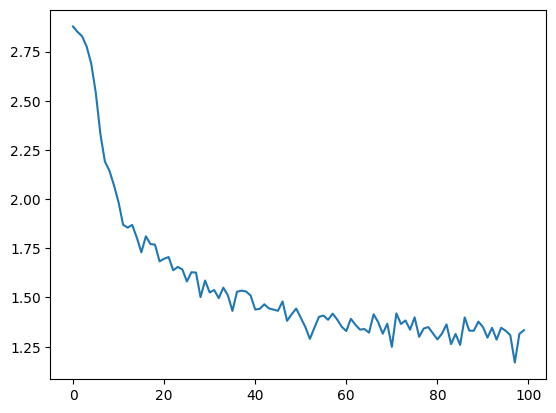

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses);

## Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




## 결과 평가

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해
모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는
혼란 행렬(confusion matrix)을 만듭니다. 혼란 행렬을 계산하기 위해
``evaluate()`` 로 많은 수의 샘플을 네트워크에 실행합니다.
``evaluate()`` 은 ``train ()`` 과 역전파를 빼면 동일합니다.




<ipython-input-41-3106c8b96506>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-41-3106c8b96506>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


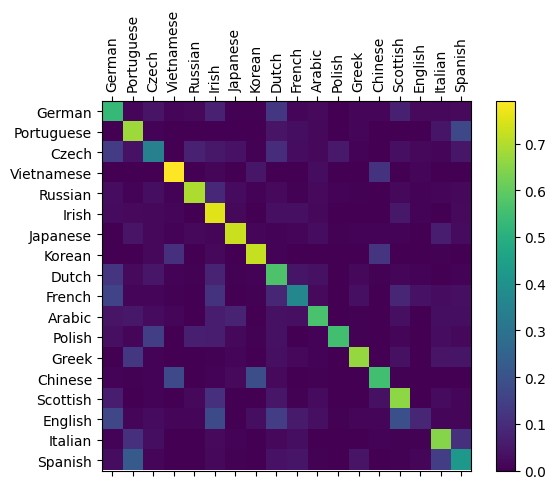

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시할 수 있습니다.
예를 들어 한국어는 중국어로 이탈리아어로 스페인어로.
그리스어는 매우 잘되는 것으로 영어는 매우 나쁜 것으로 보입니다.
(다른 언어들과의 중첩 때문으로 추정)




### Running on User Input




### 사용자 입력으로 실행




In [42]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.20) Russian
(-1.88) Czech
(-4.42) English

> Jackson
(-0.30) Scottish
(-2.10) English
(-3.38) Dutch

> Satoshi
(-0.91) Italian
(-1.30) Japanese
(-1.63) Arabic


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)_
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with ``bottle.py``)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

```sh
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```
Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




## Exercises

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network




[실용 PyTorch 저장소](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)_
의 최종 버전 스크립트는 위 코드를 몇 개의 파일로 분할했습니다.:

-  ``data.py`` (파일 읽기)
-  ``model.py`` (RNN 정의)
-  ``train.py`` (학습 실행)
-  ``predict.py`` (커맨드 라인 인자로 ``predict()`` 실행)
-  ``server.py`` (``bottle.py`` 를 사용하여 JSON API로 예측 제공)

학습과 네트워크 저장을 위해 ``train.py`` 실행.

이름으로 예측을 보기 위해 ``predict.py`` 실행:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

``server.py`` 를 실행하고 예측의 JSON 출력을 얻기 위해
http://localhost:5533/Yourname 방문.




## 연습

-  "line -> category" 의 다른 데이터 집합으로 시도해 보십시오, 예를 들어:

   -  단어 -> 언어
   -  이름 -> 성별
   -  캐릭터 이름 -> 작가
   -  페이지 제목 -> 블로그 또는 서브레딧

-  더 크고 더 나은 모양의 네트워크로 더 나은 결과를 얻으십시오.

   -  더 많은 선형 계층을 추가해 보십시오.
   -  ``nn.LSTM`` 과 ``nn.GRU`` 계층을 추가해 보십시오.
   -  위와 같은 RNN 여러 개를 상위 수준 네트워크로 결합해 보십시오.


